**Let's make some practice on data.
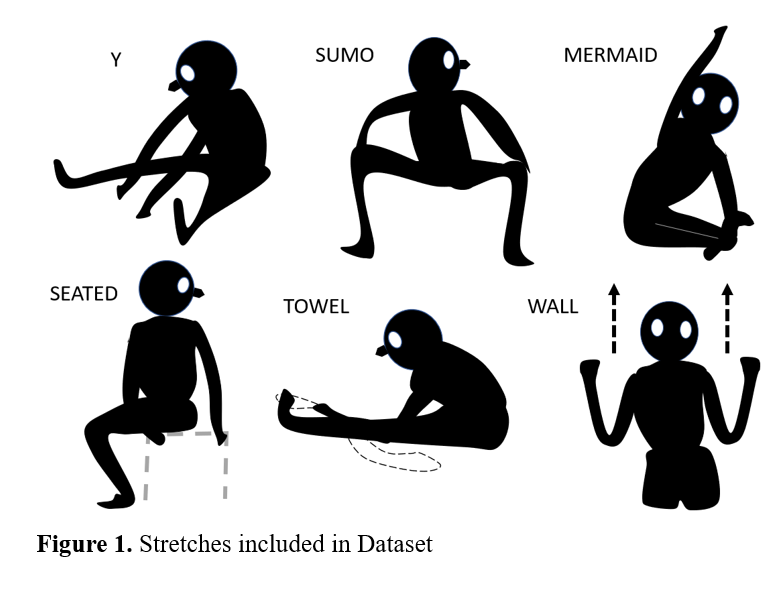
The data folder format is like below.**

> /data

> -- Subject0_Move_0/

> ------ ElbowRight_position.csv

> ------ ElbowLeft_position.csv

> ------ labels.csv

> ------ .....

> -- Subject0_Move_1/ 

> ------ ElbowRight_position.csv 

> ------ ElbowLeft_position.csv

> ------ labels.csv 

> ------ ......

**First, we take x,y,z position data for all joints and actions, we also take the label of folder in 'label.csv'.**
**As you see below, 'data_real' is pandas dataframe which contaion 75 rows of xyz joint data and 1 row of class label.**


In [ ]:
import pandas as pd
import os
rootdir = '/kaggle/input/3d-kinect-total-body-database-for-back-stretches/Data/'
data_real = pd.DataFrame()
for subdir, dirs, files in sorted(os.walk(rootdir)):
    data = pd.DataFrame()
    for file in sorted(files,reverse=True):
        if file == 'label.csv':
            label = pd.read_csv(subdir+'/'+file,header=None)
            label = label.loc[0,0]
        else:
            single_joint = pd.read_csv(subdir+'/'+file,header=None,usecols=range(0,3))
            data = pd.concat([data,single_joint],axis=1,ignore_index=True)
    data['classs'] = [label for i in range(0,len(data))]
    data_real = data_real.append(data)

**As you see, the dataframe has 75 rows of x,y,z coordinat of joints and 1 row of label, with 120 000 frames(columns).**

In [ ]:
data_real.head()
data.shape

**The labels are in string format which is not appropriate for classify, lets make them categorical integers.**

In [ ]:
data_real.classs = pd.factorize(data_real.classs)[0]

**In this step we split the label and the coordinate data as x,y.**

In [ ]:
x = data_real.drop(["classs"],axis=1)
y = data_real.classs.values

**We split data as train and test.I choose 25% test data and %75 train data.You can change it.The shuffle parameters provide us to take the data randomly.**

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test,y_train,y_test = train_test_split(x,y,test_size=0.25,shuffle=True)

**First, I wonder how RandomClassifier works.I build a RFClassifier with 100 decision tree.The results are well.**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100,random_state=1)
print('RF Fitting .............')
rf.fit(x_train,y_train)
print('RF Scoring ...........')
print('Train Set accuracy of Random Forest is : ',rf.score(x_train,y_train))
print('Test Set accuracy of Random Forest is : ',rf.score(x_test,y_test))

**Let's try this data on diffrent kind of classifiers.**

In [ ]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier()
sgd.fit(x_train,y_train)
print('nn timee................')
nn = MLPClassifier(solver='lbfgs',max_iter=20000)
nn.fit(x_train,y_train)
print('BATCH SZE : ',nn.batch_size)
print('gaus...............')
nb = GaussianNB()
nb.fit(x_train,y_train)
print('Knn:............')
knn = KNeighborsClassifier(n_neighbors = 3) #n_neighbors = k
knn.fit(x_train,y_train)
prediction = knn.predict(x_test)

print('Svm..............')
svm = SVC(random_state = 1)
svm.fit(x_train,y_train)


print("SVM accuracu is :",svm.score(x_test,y_test))
print("k={} nn score:{}".format(3,knn.score(x_test,y_test)))
print('accuracy of bayes in test data is :', nb.score(x_test,y_test))
print('acc_nn = ',nn.score(x_test,y_test))
print('acc_of_sgd is: ', sgd.score(x_test,y_test))

**As you see above, the classifier accuracies are very high which means the stretch moves in data is pretty easy.**

In [ ]:
!pip install --upgrade sklearn

**I want to show you confusion matrix but I couldn't update the scikit-learn framework.'plot_confusion_matrix' function is only available starting at 0.22 version of sklearn.**

In [ ]:
from matplotlib import pyplot as plt
from sklearn.metrics import plot_confusion_matrix
class_names=['mermaid','seated','sumo','towel','wall','Y']
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix of Bayes", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(nb, x_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

**Let's try 10 fold cross-validation on RandomForest Classifier.**

In [ ]:
from sklearn.model_selection import cross_val_score
import numpy as np
accuracy_map = cross_val_score(estimator = rf, X = x_train, y =y_train, cv = 10)
print(accuracy_map)
print("avg acc: ",np.mean(accuracy_map))
print("acg std: ",np.std(accuracy_map))

**So, the mean of the accuracies are almost 1 and the standart deviation is almost 0 which mean the results are pretty close and stable.**